In [1]:
import numpy as np
import sympy as sp
import torch
from matplotlib import pyplot as plt
from sympy import Matrix, symbols
from torch import DoubleTensor, LongTensor

from dataset import TenBarsPlanarTrussDataset
from dataset.generator import TenBarsPlanarTrussGenerator
from display import display_structure
from pathlib import Path

In [2]:
g = TenBarsPlanarTrussGenerator("data/config/10_bar_truss.yaml")

In [10]:
print(g.structure.elements_connectivity.__repr__())

array([[0, 1],
       [1, 2],
       [3, 4],
       [4, 5],
       [1, 4],
       [2, 5],
       [0, 4],
       [3, 1],
       [1, 5],
       [4, 2]])


In [3]:
g.save("data/dataset/10_bar_truss/train")
g.save("data/dataset/10_bar_truss/test", 20000)
g.save("data/dataset/10_bar_truss/validation", 20000)

Dataset saved to data\dataset\10_bar_truss\train\data.hdf5
Generation stopped at 20000 samples based on given max_size.
Dataset saved to data\dataset\10_bar_truss\test\data.hdf5
Generation stopped at 20000 samples based on given max_size.
Dataset saved to data\dataset\10_bar_truss\validation\data.hdf5


In [18]:
[[(-1)**j * i for j in range(2)] for i in range(1,6)]

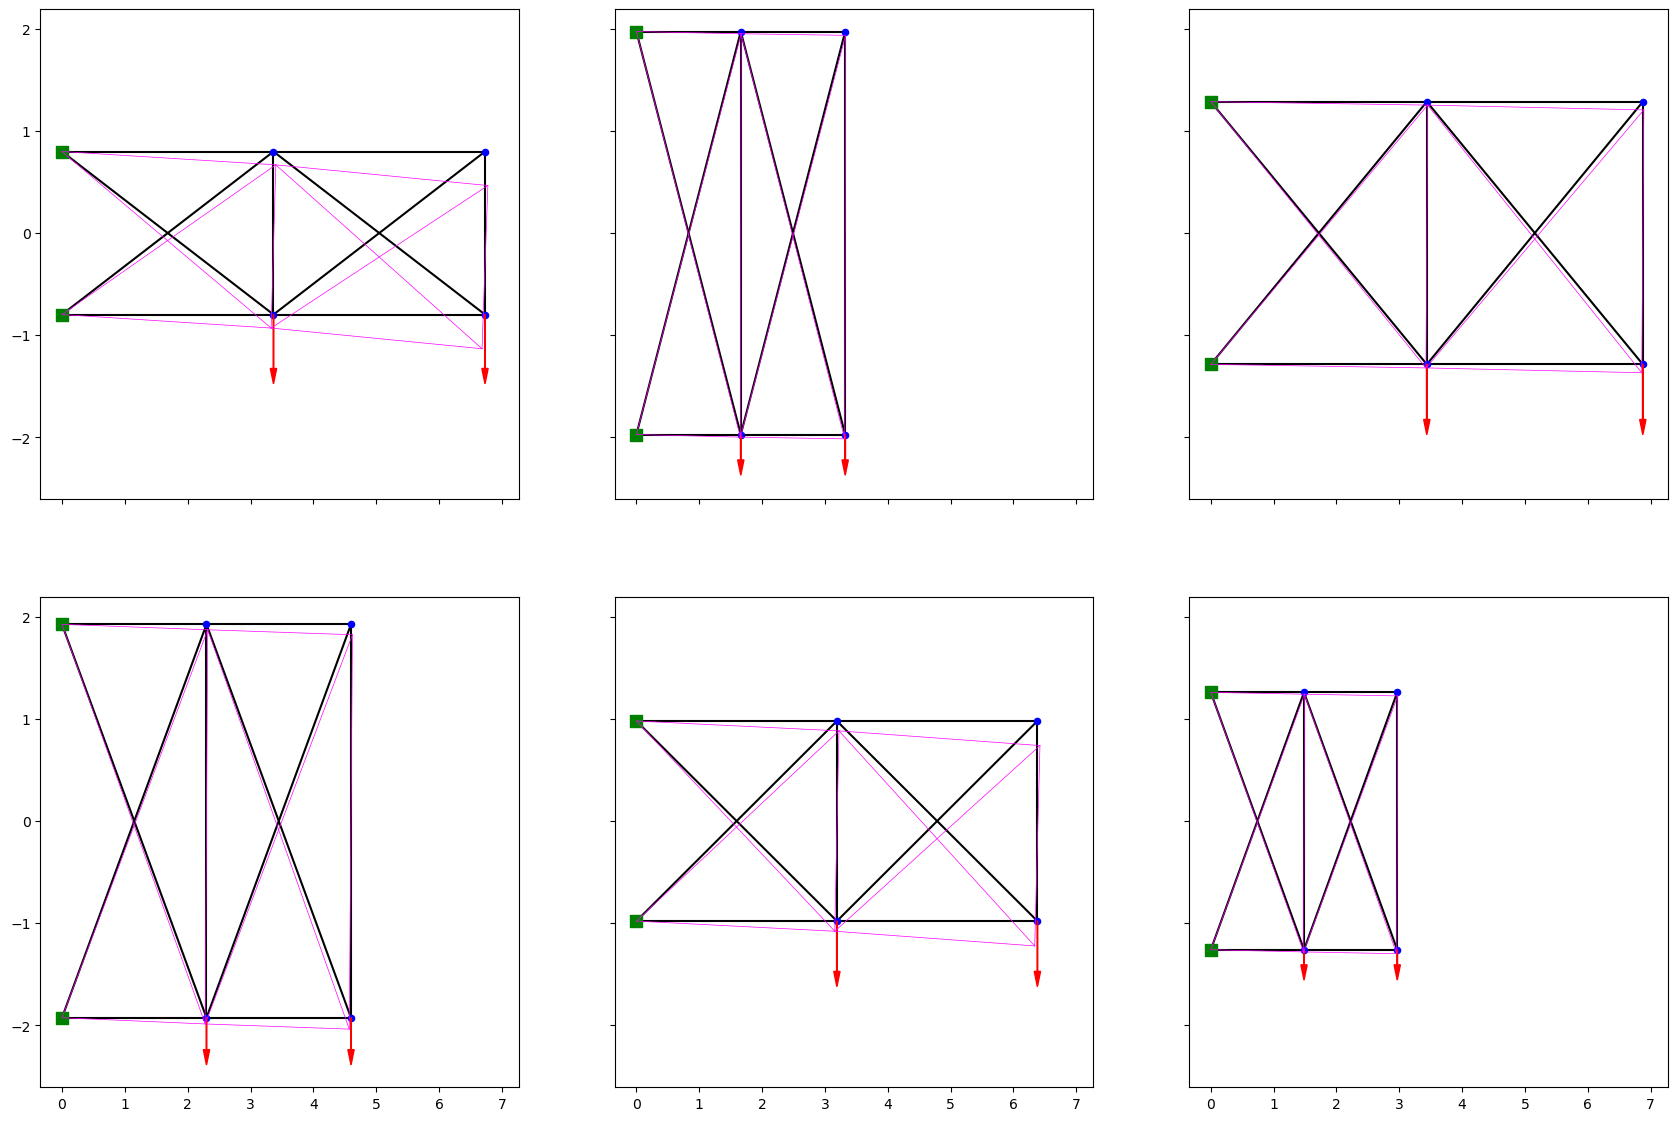

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(21, 14), sharex=True, sharey=True)
for i, r in enumerate(g):
    display_structure(ax=axs[i // 3, i % 3], def_scale=10)
    if i >= 5: break


# Torch batched stiffness assembly

In [9]:
# System setup
n_dim = 2
n_dof = 2

n_nodes = 6
n_elems = 10

batch_size = 5000

# Material
areas = torch.tensor([[10e-4 for _ in range(n_elems)] for _ in range(batch_size)],
                     dtype=torch.float64)  # (batch_size, n_elems)
youngs = torch.tensor([[70e9 for _ in range(n_elems)] for _ in range(batch_size)],
                      dtype=torch.float64)  # (batch_size, n_elems)

# Geometry
nodes = torch.tensor(np.array([g.structure.nodes_coordinates * i for i in np.linspace(1, 1, batch_size)]),
                     dtype=torch.float64)  # (batch_size, n_nodes, n_dim)

# Connectivity is assumed uniform
elems = torch.tensor(g.structure.elements_connectivity, dtype=torch.int64)  # (n_elems, 2)
supports = torch.tensor([n_dof * i + j for i, x, y in g.structure.supports for j, f in enumerate((x, y)) if f],
                        dtype=torch.int64)

K = construct_k(youngs, areas, nodes, elems, supports)
K[0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

# Symbolic stiffness matrix

In [23]:
h, l = symbols('h l')
L = [l for _ in range(4)] + [h for _ in range(2)] + [(l ** 2 + h ** 2) ** .5 for _ in range(4)]
A = [symbols(f"a_{i}") for i in range(10)]
E = [symbols(f"e_{i}") for i in range(10)]
n_dof = 2

nodes = g.structure.nodes_coordinates
elems = g.structure.elements_connectivity

elems_vec = np.array([nodes[e] - nodes[s] for s, e in elems])
elems_angle = np.array([np.arctan2(*v[::-1]) - np.arctan2(0, 1) for v in elems_vec])

K = Matrix.zeros(12, 12)
for idx in range(len(elems)):
    s_i = elems[idx][0] * n_dof
    e_i = elems[idx][1] * n_dof

    angle: float = elems_angle[idx]

    c = sp.cos(angle)
    s = sp.sin(angle)

    r = Matrix([[c, s, 0, 0], [-s, c, 0, 0], [0, 0, c, s], [0, 0, -s, c]])

    k_loc = E[idx] * A[idx] / L[idx] * Matrix([[1, 0, -1, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, 0, 0, 0]])

    k_glob = r.T @ k_loc @ r

    for i in range(n_dof):
        for j in range(n_dof):
            # Up left
            K[s_i + i, s_i + j] += k_glob[0 + i, 0 + j]
            # Up right
            K[s_i + i, e_i + j] += k_glob[0 + i, n_dof + j]
            # Down left
            K[e_i + i, s_i + j] += k_glob[n_dof + i, 0 + j]
            # Down right
            K[e_i + i, e_i + j] += k_glob[n_dof + i, n_dof + j]

for i in (0, 1, 6, 7):
    for j in range(12):
        K[i, j] = 0
        K[j, i] = 0
    K[i, i] = 1

# K = sp.nsimplify(K, tolerance=1e-10, rational=True)
# s = K.__str__()
# for i in range(10):
#     s = s.replace(f"a_{i}", f"a[{i}]")
#     s = s.replace(f"e_{i}", f"e[{i}]")
# s = s.replace("sqrt", "np.sqrt")
# s = "def f(e, a, l ,h):\n\treturn np.array" + s[6:]
# print(s)

K = sp.nsimplify(K, tolerance=1e-5)
K

Matrix([
[1, 0,                                                                                                         0,                                                                                             0,                                                   0,                                                   0, 0, 0,                                                                                                         0,                                                                                             0,                                                   0,                                                   0],
[0, 1,                                                                                                         0,                                                                                             0,                                                   0,                                                   0, 0, 0,                                         